# MPPCA demo

Mixtures of Probabilistic Principal Component Analysers is a simple yet powerful algorithm used to cluster data into linear subspaces. Its applications cover clustering, density estimation and classification.

Reference : "Mixtures of Probabilistic Principal Component Analysers", Michael E. Tipping and Christopher M. Bishop, Neural Computation 11(2), pp 443–482, MIT Press, 1999

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pickle
import gzip
import time
import collections

import mppca

%matplotlib inline

In [2]:
def print_clusters(X, clusters, mu):
    N, d = X.shape
    
    if d == 2:
        for i in range(max(clusters)+1):
            plt.scatter(X[clusters==i, 0], X[clusters==i, 1], c=np.random.rand(3,1))
            
        plt.scatter(mu[:, 0], mu[:, 1], c='k', s=100)
            
    elif d==3:
        fig = plt.figure()
        ax = Axes3D(fig)

        for i in range(max(clusters)+1):
            ax.scatter(X[clusters==i, 0], X[clusters==i, 1], X[clusters==i, 2], c=np.random.rand(3,1))
        # ax.scatter(mu[:, 0], mu[:, 1], mu[:, 2], c='k', s=100) does not work
        
    else:
        raise ValueError('Incorrect data dimensionality')

## Clustering on a cross

### Construct the dataset

In [3]:
def dataset_cross(N, d, p):
    """
    N : number of desired points
    d : space dimension
    p : proportion of the 1st branch of the cross (0<p<1)

    X : dataset
    v1, v2 : directions of the branches
    center : center of the cross
    """

    t = np.random.randn(N, 1)
    v1 = np.random.randn(1, d)
    v2 = 1.5*np.random.randn(1, d)
    center = 5.*np.random.randn(1, d)

    separation = int(round(N*p))

    X = np.zeros((N, d))
    X[:separation, :] = v1*t[:separation, :]
    X[separation:, :] = v2*t[separation:, :]
    X += 0.1*np.random.randn(N, d)
    X += center

    return X, v1, v2, center

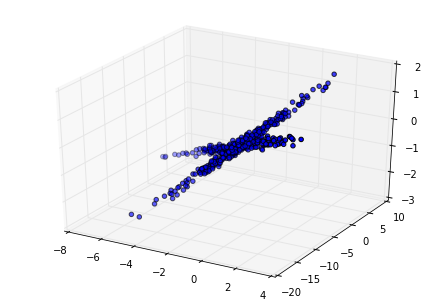

In [4]:
X, v1, v2, center = dataset_cross(N=500, d=3, p=0.4)

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:,0], X[:,1], X[:,2])

### Parameter initialization with a K-means

In [5]:
p = 2 # We expect 2 clusters
q = 1 # We expect 1-dimensional subspaces
pi, mu, W, sigma2, clusters = mppca.initialization_kmeans(X, p, q)

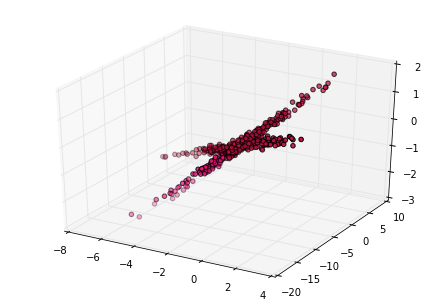

In [6]:
print_clusters(X, clusters, mu)

K-means cannot cluster correctly a cross

### Run the MPPCA algotrithm

In [7]:
niter = 500
pi, mu, W, sigma2, R, L, sigma2hist = mppca.mppca_gem(X, pi, mu, W, sigma2, niter)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Print the clusters

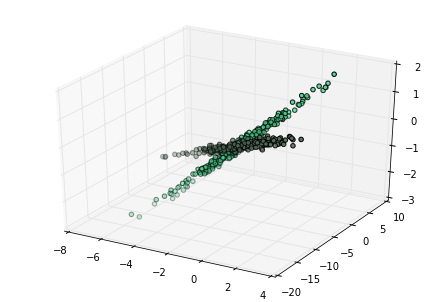

In [8]:
clusters = R.argmax(axis=1)
print_clusters(X, clusters, mu)

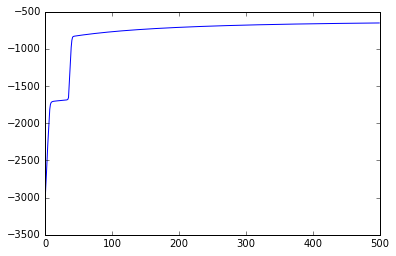

In [9]:
plt.plot(L)

Loss curve

## Decomposition of a swiss roll into linear subspaces

### Construct the dataset

In [10]:
def dataset_suissroll(N, d):
    assert (d==2)

    t = np.random.randn(N, 2)
    X = np.zeros((N, 2))
    X[:, 0] = ((t[:, 0]+4)*3+t[:, 1])*np.cos((t[:, 0]+4)*1.5)
    X[:, 1] = ((t[:, 0]+4)*3+t[:, 1])*np.sin((t[:, 0]+4)*1.5)

    return X

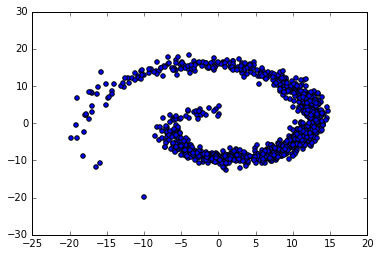

In [11]:
X = dataset_suissroll(N=1000, d=2)

plt.scatter(X[:,0], X[:,1])

### Parameter initialization with a k-means

In [12]:
p = 7 # We expect 7 clusters
q = 1 # We expect 1-dimensional subspaces
pi, mu, W, sigma2, clusters = mppca.initialization_kmeans(X, p, q)

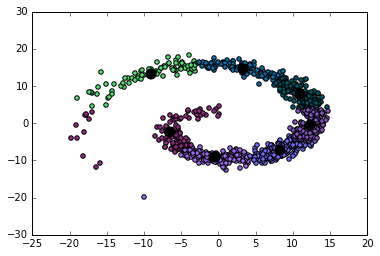

In [13]:
print_clusters(X, clusters, mu)

### Run the MPPCA algotrithm

In [14]:
niter = 500
pi, mu, W, sigma2, R, L, sigma2hist = mppca.mppca_gem(X, pi, mu, W, sigma2, niter)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Print the clusters

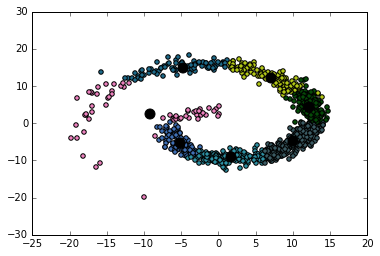

In [15]:
clusters = R.argmax(axis=1)
print_clusters(X, clusters, mu)

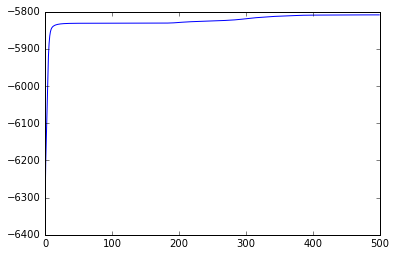

In [16]:
plt.plot(L)

## Classification on the MNIST dataset

### Load the dataset

In [17]:
f = gzip.open('mnist.pkl.gz', 'r')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
f.close()

train_data, train_labels = train_set
valid_data, valid_labels = valid_set
test_data, test_labels = test_set

d = train_data.shape[1]
K = 10 # Number of different numbers

In [18]:
len(train_set[0]), len(valid_set[0]), len(test_set[0])

(50000, 10000, 10000)

label:7


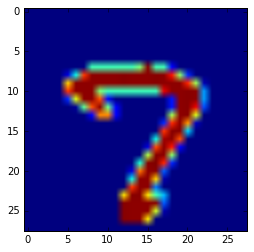

In [19]:
i = 52
plt.imshow(train_data[i].reshape((28, 28)))
print('label:%d'%train_labels[i])

### Train the model

In [20]:
n_train = 100  # Faster computations at the expense of results

# Optimal p, q values depend on n_train.
# NB: On real applications, these hyperparameters should be trained
# using the validation set!
p = 3 # Number of expected clusters (per number)
q = 2 # Dimension of the subspaces

niter = 100

pi = np.zeros(p*K)
mu = np.zeros((p*K, d))
W = np.zeros((p*K, d, q))
sigma2 = np.zeros(p*K)
cluster_labels = np.zeros(p*K, dtype=np.int32)

for i in range(K):
    X = train_data[train_labels == i][:n_train, :]

    pi_i, mu_i, W_i, sigma2_i, clusters = mppca.initialization_kmeans(X, p, q)

    t = time.time()
    pi_i, mu_i, W_i, sigma2_i, R, L, sigma2hist = mppca.mppca_gem(
        X, pi_i, mu_i, W_i, sigma2_i, niter)
    print('GEM took %f seconds.'%(time.time()-t))
    
    pi[p*i:p*(i+1)] = pi_i
    mu[p*i:p*(i+1), :] = mu_i
    W[p*i:p*(i+1), :, :] = W_i
    sigma2[p*i:p*(i+1)] = sigma2_i
    cluster_labels[p*i:p*(i+1)] = i

....................................................................................................GEM took 21.422765 seconds.
....................................................................................................GEM took 17.008500 seconds.
....................................................................................................GEM took 18.368042 seconds.
....................................................................................................GEM took 16.966522 seconds.
....................................................................................................GEM took 18.250899 seconds.
....................................................................................................GEM took 23.181151 seconds.
....................................................................................................GEM took 20.651325 seconds.
....................................................................................................GEM 

### Visualize some parameters

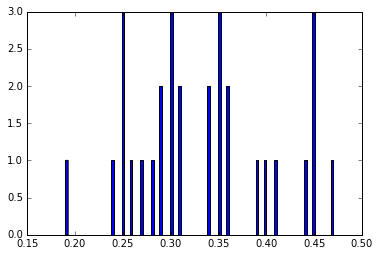

In [21]:
# cluster repartition
h = plt.hist(pi, bins=100)

label=4


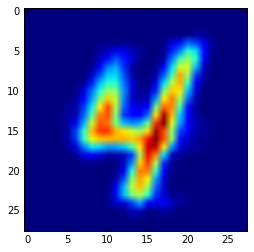

In [22]:
i = 12
# center of the i-th cluster
plt.imshow(mu[i, :].reshape((28, 28)))
print('label=%d'%cluster_labels[i])

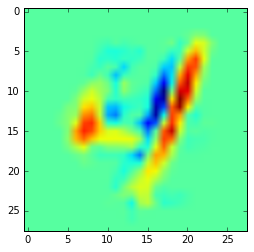

In [23]:
# Plot the 1st principal component of the i-th cluster
plt.imshow(W[i, :, 0].reshape((28, 28)))

### Predict on the test set

In [24]:
R = mppca.mppca_predict(test_data, pi, mu, W, sigma2)

In [25]:
clusters = R.argmax(axis=1)
predicted_numbers = cluster_labels[clusters]

In [26]:
error_rate = (test_labels!=predicted_numbers).sum()/len(test_labels)
print(error_rate)

0.1323


The MPMCA predictor has an error rate of 13-14%.

With `n_train`=500, `p`=10, `q`=7, the error rate is around 3.9% (from previous Matlab computations)